In [2]:
!pip install hdbscan

     |████████████████████████████████| 4.7MB 4.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2305992 sha256=e0df28584f938ec45f7e169b38d832dfb0ac9539e4ef162b2f2eddff7227aea4
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan


In [3]:
!pip install folium

In [4]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot') 
import pandas as pd 
import numpy as np 
from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN 
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs 
from sklearn.neighbors import KNeighborsClassifier 
from ipywidgets import interactive 

from collections import defaultdict 
import hdbscan
import folium 
import re 
cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']*10

In [5]:
from google.colab import files    #uploading a dataset from the local drive
uploaded = files.upload()

Saving taxi_data.csv to taxi_data.csv


In [6]:
import io
df = pd.read_csv(io.BytesIO(uploaded['taxi_data.csv']))

In [8]:
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [9]:
df.duplicated(subset=['LON','LAT']).values.any()

True

In [10]:
df.isna().values.any()

True

In [11]:
df.shape

(838, 3)

In [13]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON','LAT'],keep='first',inplace=True)

In [14]:
df.shape

(823, 3)

In [16]:
X = np.array(df[['LON','LAT']],dtype='float64')

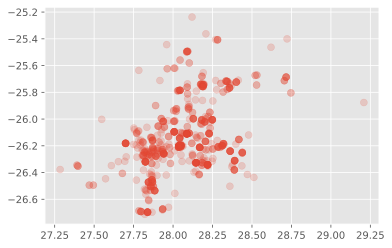

In [18]:
plt.scatter(X[:,0],X[:,1], alpha=0.2,s=50)


**Visualizing Geographical Data**

In [28]:
m = folium.Map(location=[df.LAT.mean(),df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

for _,row in df.iterrows():
  folium.CircleMarker(
      location=[row.LAT,row.LON],
      radius=5,
      popup= re.sub(r'[^a-zA-Z ]+', '' , row.NAME),
      color='1787FE',
      fill=True,
      fill_color='1787FE'

 ).add_to(m)


In [30]:
m

In [39]:
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2, cluster_std=0.5, random_state=4)

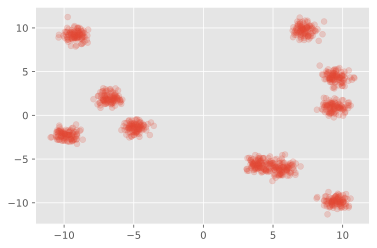

In [40]:
plt.scatter(X_blobs[:,0],X_blobs[:,1], alpha=0.2)

In [45]:
from google.colab import files    #uploading a dataset from the local drive
uploaded = files.upload()


Saving sample_clusters.npy to sample_clusters.npy


In [47]:
class_predictions = np.load('sample_clusters.npy')

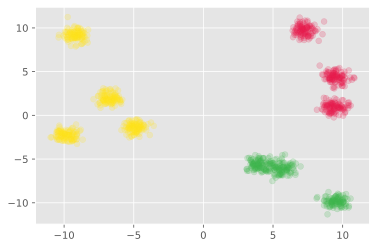

In [49]:
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
  X = X_blobs[class_predictions==unique_cluster]
  plt.scatter(X[:,0],X[:,1],alpha=0.2, c = cols[unique_cluster])

In [51]:
silhouette_score(X_blobs,class_predictions)

0.6657220862867241

In [52]:
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2, cluster_std=1, random_state=4)

In [53]:
data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [54]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [56]:
X = np.array(df[['LON', 'LAT']], dtype='float64')
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

In [57]:
df.head()

,LON,LAT,NAME,CLUSTER_kmeans70
0,28.17858,-25.73882,11th Street Taxi Rank,15
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank,15
2,27.83239,-26.53722,Adams Road Taxi Rank,5
3,28.12514,-26.26666,Alberton City Mall Taxi Rank,33
4,28.10144,-26.10567,Alexandra Main Taxi Rank,18


In [84]:
def create_map(df, cluster_column):
  m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')
  for _, row in df.iterrows():
    if row[cluster_column] == -1:
      cluster_colour = '#000000'
    else:
      cluster_colour = cols[row[cluster_column]]
  folium.CircleMarker(location=[row['LAT'], row['LON']],radius=5,popup=re.sub(r'[^a-zA-Z]+', '', row.NAME),color = cluster_colour,fill=True,fill_colour = cluster_colour).add_to(m)
  return m      




m = create_map(df, 'CLUSTER_kmeans70')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=99
Silhouette Score: 0.2992028900672389


In [85]:
m

In [64]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}')

100%|██████████| 98/98 [00:29<00:00,  3.28it/s]

K=98
Silhouette Score: 0.6971995093340411


In [65]:
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])

new = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(dummy)])

In [66]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_

df['CLUSTERS_DBSCAN'] = class_predictions

In [86]:
m = create_map(df, 'CLUSTERS_DBSCAN')

    
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138250288208
Silhouette outliers as singletons: 0.5667489350583482


In [87]:
m

In [88]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, 
                        cluster_selection_epsilon=0.01)

In [89]:
class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [90]:
m = create_map(df, 'CLUSTER_HDBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504356844786
Silhouette outliers as singletons: 0.638992483305273


In [91]:
classifier = KNeighborsClassifier(n_neighbors=1)

In [93]:
df_train = df[df.CLUSTER_HDBSCAN!=-1]
df_predict = df[df.CLUSTER_HDBSCAN==-1]

In [94]:
X_train = np.array(df_train[['LON', 'LAT']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_predict = np.array(df_predict[['LON', 'LAT']], dtype='float64')

In [95]:
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_predict)

In [96]:
print(predictions)
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']

[26 41 13 44 57 26 34  4 60 60 16 16 61 24 51 51 51 58 41 63 13 45 15 45
 45  6  0 17 26 26 26 49 49 53 49 13 61 26 26 39 65 31 31 31  0 46 46 21
 58 60  6  5 24  1 63 34 64 36 36 16  7  3 64 41 13 39 39 39 41 40 40 25
 59 57 61 61 62 26 15 15 59 63  6 19 61 61 48  4 41 21 64 64 64 61 61 21
 23 38 31 41 55 55]


In [97]:
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions

In [98]:
m = create_map(df, 'CLUSTER_hybrid')

In [99]:
m

In [100]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 66
Silhouette: 0.5849126494706486


Text(0.5, 0, 'Cluster Sizes')

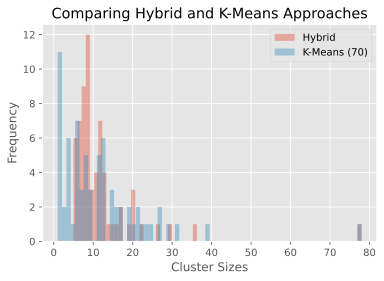

In [101]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4, 
                                              label='Hybrid')
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=70, alpha=0.4,
                                               label='K-Means (70)')
plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')
plt.xlabel('Cluster Sizes')